<a href="https://colab.research.google.com/github/varun-kovelamudi/Face-Mask-Detection/blob/main/CNN_pretrained_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 27 21:04:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              37W /  72W |   4321MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.optimizers import Adam

dataset_path= r"/content/drive/MyDrive/FMD_DATASET"
# Define the categories
categories = ['without_mask',
              'with_mask']

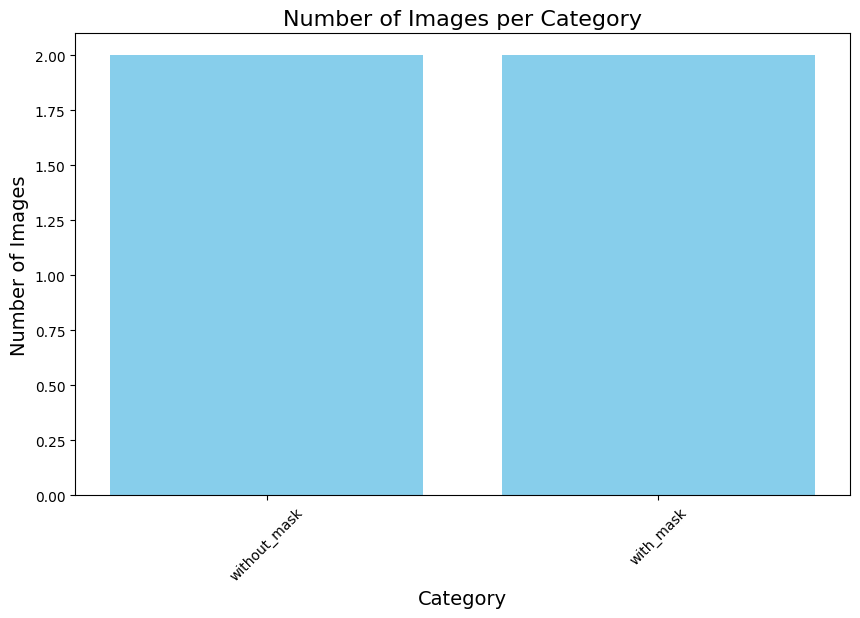

In [ ]:
# Function to count images in each category and plot a bar graph
def plot_category_counts(dataset_path, categories):
    # Lists to store category names and image counts
    category_names = []
    image_counts = []

    # Iterate over each category to count the images
    for category in categories:
        image_dir = os.path.join(dataset_path, category)
        num_images = len(os.listdir(image_dir))

        category_names.append(category)
        image_counts.append(num_images)

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(category_names, image_counts, color='skyblue')
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title('Number of Images per Category', fontsize=16)
    plt.xticks(rotation=45)  # Rotate category names for better readability
    plt.show()

# Now, call the function with your dataset path and categories
plot_category_counts(dataset_path, categories)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(320, 320),
    batch_size=32,
    class_mode='binary',  # Adjusted for binary classification
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(320, 320),
    batch_size=32,
    class_mode='binary',  # Adjusted for binary classification
    subset='validation'
)

Found 7646 images belonging to 2 classes.
Found 1910 images belonging to 2 classes.


In [ ]:
# Accessing class_indices attribute
class_indices = validation_generator.class_indices

# Getting class names from the class_indices dictionary
class_names = list(class_indices.keys())

# Printing class names
print("Class names in the training generator:")
for name in class_names:
    print(name)

Class names in the training generator:
with_mask
without_mask


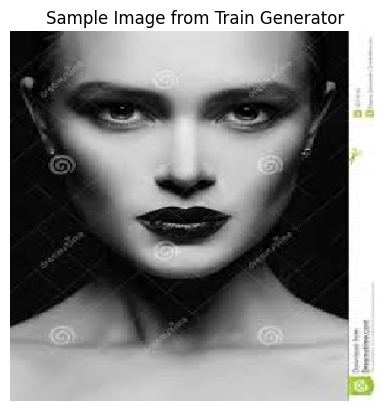

Label for this image: 1.0


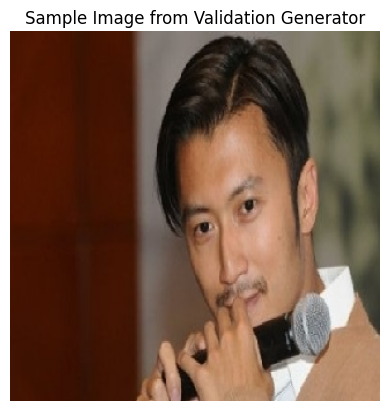

Label for this image: 1.0


In [ ]:
# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

# Plot the first image in the batch
plt.imshow(images[0])
plt.title("Sample Image from Train Generator")
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# If you also want to display the label for this image
print("Label for this image:", labels[0])


# Get a batch of images and labels from the train_generator
images, labels = next(validation_generator)

# Plot the first image in the batch
plt.imshow(images[0])
plt.title("Sample Image from Validation Generator")
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# If you also want to display the label for this image
print("Label for this image:", labels[0])


In [ ]:
# Load the base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(320, 320, 3), pooling='avg')

In [ ]:
# Unfreeze the top 100 layers of the base model
base_model.trainable = True  # Make the base model trainable
for layer in base_model.layers[:-100]:
    layer.trainable = False  # Freeze layers except for the last 100

# Adding custom layers on top of the base model
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

# Defining the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compilation with a suitable learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Setting up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/MaskDetection/best_pretrainednn_model', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks)


model.save('/content/drive/MyDrive/MaskDetection/final_pretrainednn_model')

Epoch 1/100
 95/239 [==========>...................] - ETA: 28:07 - loss: 0.1382 - accuracy: 0.9431

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


239/239 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9673 
Epoch 1: val_loss improved from inf to 5.45400, saving model to /content/drive/MyDrive/MaskDetection/best_pretrainednn_model
239/239 [==============================] - 3211s 13s/step - loss: 0.0869 - accuracy: 0.9673 - val_loss: 5.4540 - val_accuracy: 0.5010 - lr: 1.0000e-04
Epoch 2/100
 28/239 [==>...........................] - ETA: 47s - loss: 0.0436 - accuracy: 0.9899

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


239/239 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9922
Epoch 2: val_loss did not improve from 5.45400
239/239 [==============================] - 66s 274ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 7.1138 - val_accuracy: 0.5152 - lr: 1.0000e-04
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9912
Epoch 3: val_loss did not improve from 5.45400
239/239 [==============================] - 64s 268ms/step - loss: 0.0246 - accuracy: 0.9912 - val_loss: 6.1798 - val_accuracy: 0.5073 - lr: 1.0000e-04
Epoch 4/100
239/239 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9937
Epoch 4: val_loss improved from 5.45400 to 1.76333, saving model to /content/drive/MyDrive/MaskDetection/best_pretrainednn_model
239/239 [==============================] - 82s 342ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 1.7633 - val_accuracy: 0.6183 - lr: 1.0000e-04
Epoch 5/100
 16/239 [=>......................

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


239/239 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9954
Epoch 5: val_loss did not improve from 1.76333
239/239 [==============================] - 66s 276ms/step - loss: 0.0132 - accuracy: 0.9954 - val_loss: 2.7422 - val_accuracy: 0.5649 - lr: 1.0000e-04
Epoch 6/100
239/239 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9953
Epoch 6: val_loss improved from 1.76333 to 1.07491, saving model to /content/drive/MyDrive/MaskDetection/best_pretrainednn_model
239/239 [==============================] - 82s 342ms/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 1.0749 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 7/100
225/239 [===========================>..] - ETA: 3s - loss: 0.0148 - accuracy: 0.9946

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


239/239 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9949
Epoch 7: val_loss did not improve from 1.07491
239/239 [==============================] - 66s 274ms/step - loss: 0.0141 - accuracy: 0.9949 - val_loss: 1.5138 - val_accuracy: 0.7209 - lr: 1.0000e-04
Epoch 8/100
239/239 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9962
Epoch 8: val_loss did not improve from 1.07491
239/239 [==============================] - 62s 258ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 8.0704 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 9/100
239/239 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9956
Epoch 9: val_loss did not improve from 1.07491
239/239 [==============================] - 64s 269ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 1.1995 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 10/100
239/239 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9970
Epoch 10: val_loss did not im